# Convolutional Neural Networks usando Keras e CIFAR-10

### 1. Carregando a base CIFAR-10 (imagens rotuladas em macro categorias)

*** Mais informações em https://www.cs.toronto.edu/~kriz/cifar.html ***

In [1]:
import keras
from keras.datasets import cifar10

#carregando o dataset pré-embaralhado de treinamento bem como os dados de teste
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Using TensorFlow backend.


170508288/170498071 [==============================] - 65s 0us/step


### 2. Visualizando as primeiras 24 imagens do dataset de treinamento

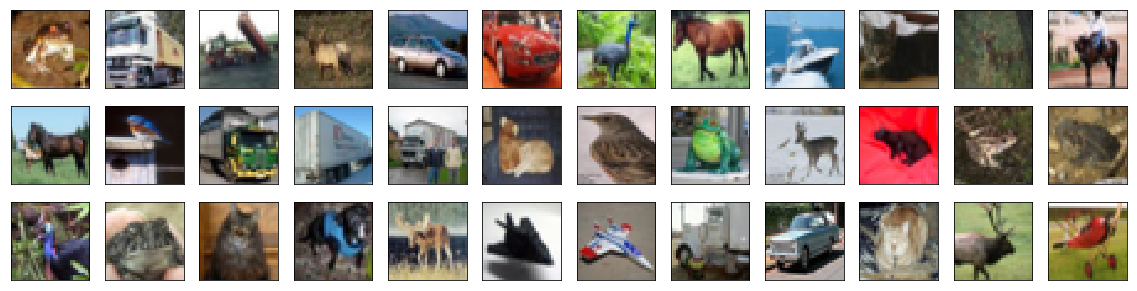

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20,5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))

### 3. Redimensionando as imagens e dividindo cada pixel em cada imagem por 255

In [0]:
# redimensionamento [0,255] --> [0,1]
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

### 4.  Dividindo o dataset em treinamento, teste e validação

In [4]:
from keras.utils import np_utils

# "one-hot encode" aplicado aos rótulos
num_classes = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# divindo dataset de treinamento em treinamento, teste e validação
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

# impressão da forma do conjunto de treino
print('x_train shape:', x_train.shape)

# impressão do número de imagens nos datasets de treinamento, teste e validação
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_valid.shape[0], 'validation samples')

('x_train shape:', (45000, 32, 32, 3))
(45000, 'train samples')
(10000, 'test samples')
(5000, 'validation samples')


### 5. Definindo a arquitetura do modelo (IMPORTANTE!)

* 3 camadas convolucionais de tamanho progressivamente crescente
* Máximo de camadas de "pooling" (2x2) seguidas por tais 3 camadas convolucionais
* Uma camada do tipo totalmente conectada de 100 neurônios
* Últimas camadas do tipo totalmente conectadas de 10 saídas (10 classes de categoria de imagem)
* "Dropout" de 0,2-0,3

In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

# tentem com outras funções de ativação
# mais informações em https://keras.io/activations/

model.summary()

W1105 20:19:42.523442 140360066828160 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1105 20:19:42.534415 140360066828160 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1105 20:19:42.546871 140360066828160 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1105 20:19:42.596143 140360066828160 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W1105 20:19:42.625886 140360066828160 module_wrapper.py:139] From /usr/loca

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         32896     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 128)         0         
__________

### 6. Compilando o modelo

In [6]:
# compilando o modelo escolhendo como se dará nossa perda, otimização e métricas (parâmetros do Keras)
# mais informações em https://keras.io/losses/
# mais informações em https://keras.io/optimizers/
# mais informações em https://keras.io/metrics/
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])

W1105 20:19:42.717382 140360066828160 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1105 20:19:42.743803 140360066828160 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



### 7. Treinando o modelo

In [7]:
from keras.callbacks import ModelCheckpoint   

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
hist = model.fit(x_train, y_train, batch_size=64, epochs=15,
          validation_data=(x_valid, y_valid), callbacks=[checkpointer], 
          verbose=2, shuffle=True)

# tentem mudar o número de épocas de treinamento e verificar o comportamento de nosso algoritmo

W1105 20:19:42.907943 140360066828160 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1105 20:19:43.091326 140360066828160 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W1105 20:19:43.099108 140360066828160 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

W1105 20:19:43.191973 140360066828160 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:2741: The name tf.Session is deprecated. Please use tf.compat.v1.Se

Train on 45000 samples, validate on 5000 samples
Epoch 1/15


W1105 20:19:43.447983 140360066828160 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:206: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



 - 65s - loss: 1.7497 - acc: 0.3659 - val_loss: 1.7548 - val_acc: 0.3928

Epoch 00001: val_loss improved from inf to 1.75478, saving model to model.weights.best.hdf5
Epoch 2/15
 - 64s - loss: 1.3907 - acc: 0.5050 - val_loss: 1.6281 - val_acc: 0.4448

Epoch 00002: val_loss improved from 1.75478 to 1.62812, saving model to model.weights.best.hdf5
Epoch 3/15
 - 64s - loss: 1.2426 - acc: 0.5598 - val_loss: 1.2040 - val_acc: 0.5778

Epoch 00003: val_loss improved from 1.62812 to 1.20396, saving model to model.weights.best.hdf5
Epoch 4/15
 - 63s - loss: 1.1450 - acc: 0.5974 - val_loss: 1.3230 - val_acc: 0.5364

Epoch 00004: val_loss did not improve from 1.20396
Epoch 5/15
 - 64s - loss: 1.0800 - acc: 0.6213 - val_loss: 0.9544 - val_acc: 0.6698

Epoch 00005: val_loss improved from 1.20396 to 0.95439, saving model to model.weights.best.hdf5
Epoch 6/15
 - 64s - loss: 1.0352 - acc: 0.6380 - val_loss: 1.0256 - val_acc: 0.6410

Epoch 00006: val_loss did not improve from 0.95439
Epoch 7/15
 - 64s -

### 8. Carregando o modelo com a melhor precisão de validação

In [0]:
# carregando os pesos que geraram a melhor precisão de validação
model.load_weights('model.weights.best.hdf5')

### 9. Cálculo da precisão de classificação no dataset de testes

In [9]:
# avaliar e imprimir a precisão do teste
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])

('\n', 'Test accuracy:', 0.7053)


### 10. Visualizar algumas predições

As visualizações podem nos dar algumas dicas sobre por que a rede classifica erroneamente alguns objetos.

In [0]:
# obtendo previsões no conjunto de testes
y_hat = model.predict(x_test)

# definindo rótulos de texto (rótulos disponíveis na fonte original: https://www.cs.toronto.edu/~kriz/cifar.html)
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

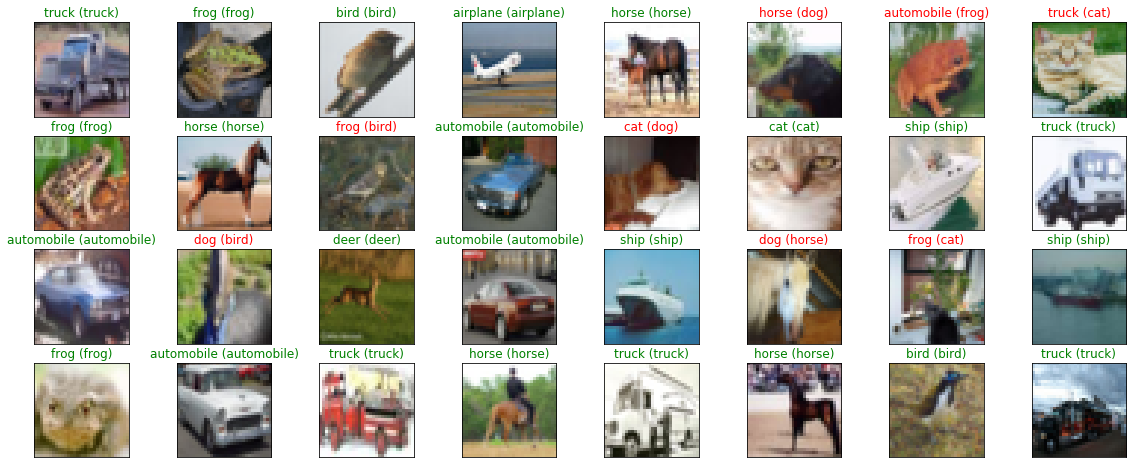

In [11]:
# plot de amostra aleatória de imagens de teste, rótulos preditos e a "ground truth" advinda do dataset CIFAR-10
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))
    # amostras corretamente classificadas em verde, incorretamente classificadas em vermelho
